<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

## Importing dependencies and define helper functions

In [124]:
import gymnasium
from gymnasium.wrappers import RecordVideo
from gymnasium import logger as gymlogger

import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline 

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# Set gym logger level to show only errors
import logging
# gymlogger.setLevel(logging.ERROR)

# # Function to display a recorded video from the 'video/' directory
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video).decode('ascii')
        display_html = f'''
        <video alt="Recorded video" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
        </video>
        '''
        ipythondisplay.display(HTML(display_html))
    else: 
        print("⚠️ Could not find any video in the 'video/' folder.")


## Tutorial: Loading CartPole environment

In [125]:
env = gymnasium.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [126]:
observation = env.reset()
print("initial observation", observation)
print("actionSpace{}".format(env.action_space))
print("actionSpace{}".format(env.observation_space))

initial observation (array([ 0.03630047, -0.04800527, -0.02227082, -0.02938143], dtype=float32), {})
actionSpaceDiscrete(2)
actionSpaceBox([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [127]:
observation, reward, terminated, truncated, info = env.step(0)
done = terminated or truncated

print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Done?", done)


New observations after choosing action 0: [ 0.03534037 -0.24280088 -0.02285845  0.25619245]
Reward for this step: 1.0
Done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [128]:
observation, info = env.reset()
cumulative_reward = 0
terminated = False
truncated = False

while not (terminated or truncated):
    observation, reward, terminated, truncated, info = env.step(0)
    cumulative_reward += reward

print("Cumulative reward for this round:", cumulative_reward)


Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

Initialize of parameters


In [162]:
# Parameters
LEARNING_RATE = 0.09
DISCOUNT = 0.95
EPISODES = 80000
epsilon = 1.0
epsilon_decay = 0.99944
min_epsilon = 0.01
print("initial observation", observation)
print("actionSpace{}".format(env.action_space))
print("actionSpace{}".format(env.observation_space))
# State space discretization
bins = [6, 6, 12, 50]

lower_bounds = np.array([-4.8, -5.0, -0.418, -5.0])
upper_bounds = np.array([4.8, 5.0, 0.418, 5.0])

bin_sizes = (upper_bounds - lower_bounds) / bins

# Q-table
q_table = np.random.uniform(low=0, high=1, size=(bins + [env.action_space.n]))

initial observation [ 0.01611979 -0.02047234  0.01338207  0.04969927]
actionSpaceDiscrete(2)
actionSpaceBox([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [163]:
def get_discrete_state(state):
    clipped = np.clip(state, lower_bounds, upper_bounds)
    discrete = ((clipped - lower_bounds) / bin_sizes)
    discrete = np.clip(discrete, 0, np.array(bins) - 1).astype(int) # prevent overflow
    return tuple(discrete)


For Task 1, we can show the observation and chosen action below:

In [164]:
rewards_per_episode = []


In [ ]:
env = gymnasium.make("CartPole-v1")

for episode in range(EPISODES):
    state, _ = env.reset()
    discrete_state = get_discrete_state(state)
    total_reward = 0
    done = False
    terminated = False
    truncated = False


    while not (terminated or truncated):
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[discrete_state])

        # next_state, reward, done, _, _ = env.step(action)
        next_state, reward, terminated, truncated, info = env.step(action)

        next_discrete_state = get_discrete_state(next_state)

        # Update Q-table using Bellman Equation
        max_future_q = np.max(q_table[next_discrete_state])
        current_q = q_table[discrete_state + (action,)]
        new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[discrete_state + (action,)] = new_q

        discrete_state = next_discrete_state
        total_reward += reward

    # Decay epsilon
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay
        epsilon = max(min_epsilon, epsilon)

    rewards_per_episode.append(total_reward)

    # Optional: print progress
    if episode % 500 == 0:
        avg = np.mean(rewards_per_episode[-100:])
        print(f"Episode {episode} | Avg Reward (last 100): {avg:.2f} | Epsilon: {epsilon:.4f}")

Episode 0 | Avg Reward (last 100): 10.00 | Epsilon: 0.9994
Episode 500 | Avg Reward (last 100): 25.02 | Epsilon: 0.7553
Episode 1000 | Avg Reward (last 100): 36.13 | Epsilon: 0.5708
Episode 1500 | Avg Reward (last 100): 78.12 | Epsilon: 0.4314
Episode 2000 | Avg Reward (last 100): 174.20 | Epsilon: 0.3260
Episode 2500 | Avg Reward (last 100): 234.27 | Epsilon: 0.2464
Episode 3000 | Avg Reward (last 100): 320.53 | Epsilon: 0.1862
Episode 3500 | Avg Reward (last 100): 298.74 | Epsilon: 0.1407
Episode 4000 | Avg Reward (last 100): 258.75 | Epsilon: 0.1063
Episode 4500 | Avg Reward (last 100): 271.10 | Epsilon: 0.0804
Episode 5000 | Avg Reward (last 100): 500.00 | Epsilon: 0.0607
Episode 5500 | Avg Reward (last 100): 470.82 | Epsilon: 0.0459


In [151]:
def Reinforcement_Learning_agent(state):
    discrete_state=get_discrete_state(state)
    action = np.argmax(q_table[discrete_state]) 
    return action

## Task 2: Demonstrate the effectiveness of the RL agent

In [152]:
env = gymnasium.make("CartPole-v1")
test_episodes=100
episode_results = []
cumulative_reward_results = int(0)
for test_episode in range(test_episodes):
    observation, info = env.reset()
    state = observation

    cumulative_reward = 0
    terminated = False
    truncated = False

    while not (terminated or truncated):
        action = Reinforcement_Learning_agent(state)
        
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        cumulative_reward += reward
        cumulative_reward_results+=reward
        #env.render()
    episode_results.append(cumulative_reward)
  #print("Cumulative reward for this round:", cumulative_reward)

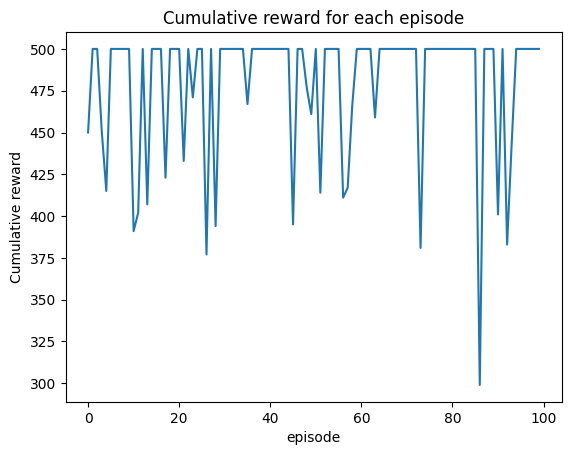

In [153]:
# episode_results = np.random.randint(150, 250, size=100)
plt.plot(episode_results)

plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [145]:
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [146]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import random

# Create environment with correct render mode
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Wrap it to record video
env = RecordVideo(env, video_folder="./video")

# Reset environment and unpack the new return format
observation, info = env.reset()

cumulative_reward = 0
terminated = False
truncated = False

while not (terminated or truncated):
        action = Reinforcement_Learning_agent(state)
        
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        cumulative_reward += reward
        cumulative_reward_results+=reward

env.close()

print("Cumulative reward:", cumulative_reward)

# Show video if you're in Jupyter
show_video()


Cumulative reward: 500.0
